In [1]:
# -*- coding: utf-8 -*-
import keras
keras.__version__

Using TensorFlow backend.


'2.2.5'

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
filepath = r"C:\Users\Secain\Desktop\valhalla\wordv2vec\sgns.renmin.bigram-char"

embedding_dict = {}
with open(filepath, 'r', encoding='utf-8') as f:
    print(f.readline())
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_dict[word] = coefs
            
pd.to_pickle(embedding_dict, 'embedding_dict.pk')

In [ ]:
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# We create a tokenizer, configured to only take
# into account the top-1000 most common words
tokenizer = Tokenizer(num_words=10)
# This builds the word index
tokenizer.fit_on_texts(samples)

# This turns strings into lists of integer indices.
sequences = tokenizer.texts_to_sequences(samples)

# You could also directly get the one-hot binary representations.
# Note that other vectorization modes than one-hot encoding are supported!
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

# This is how you can recover the word index that was computed
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

In [ ]:
from keras.layers import Embedding

# 设置Embedding矩阵
embedding_layer = Embedding(1000, 64)
embedding_layer.set_weights([embedding_matrix])
embedding_layer.trainable = False

# Advanced usage of recurrent neural networks

In [4]:
with open('./datasets/jena_climate_2009_2016.csv')as f:
    data = f.read()

lines = data.split('\n')
header = (lines[0].split(','))
data = [line.split(',') for line in lines[1:]]
df = pd.DataFrame(data, columns=header)
df.head(3) # 一共420551行

,"""Date Time""","""p (mbar)""","""T (degC)""","""Tpot (K)""","""Tdew (degC)""","""rh (%)""","""VPmax (mbar)""","""VPact (mbar)""","""VPdef (mbar)""","""sh (g/kg)""","""H2OC (mmol/mol)""","""rho (g/m**3)""","""wv (m/s)""","""max. wv (m/s)""","""wd (deg)"""
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60


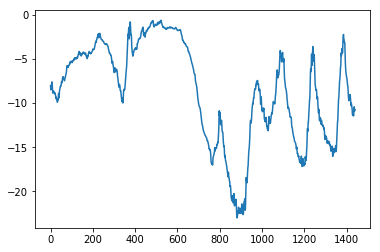

In [47]:
temp = [float(data[i][2]) for i in range(len(data))]
plt.plot(range(1440), temp[:1440]) # 前十天的温度

In [5]:
float_data = np.zeros((len(data), len(data[0])-1))
for i, line in enumerate(data):
    float_data[i] = [float(x) for x in line[1:]]

# 对训练集进行normalization
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [6]:
def generator(float_data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(float_data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback # 样本已到尾部时回到起点重新开始
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           float_data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = float_data[indices]
            targets[j] = float_data[rows[j] + delay][1]
        yield samples, targets

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
test_steps = (len(float_data) - 300001 - lookback) // batch_size

**开始使用黑盒深度学习模型解决温度预测问题之前，我们先尝试一种基于常识的简单方法。**

它可以作为合理性检查，还可以建立一个基准，更高级的机器学习模型需要打败这个基准才能表现出其有效性。面对一个尚没有已知解决方案的新问题时，这种基于常识的基准方法很有用。一个经典的例子就是不平衡的分类任务，其中某些类别比其他类别更常见。如果数据集中包含90% 的类别 A 实例和 10% 的类别 B 实例，那么分类任务的一种基于常识的方法就是对新样本始终预测类别“A”。这种分类器的总体精度为90%，因此任何基于学习的方法在精度高于90%时才能证明其有效性。

一种基于常识的方法就是始终预测 24 小时后的温度等于现在的温度。我们使用平均绝对误差（MAE）指标来评估这种方法。
得到的 MAE 为 0.29。因为温度数据被标准化成均值为 0、标准差为 1，所以无法直接对这个值进行解释。它转化成温度的平均绝对误差为 0.29 × temperature_std 摄氏度，即 2.57℃。

In [62]:
# np.mean(np.abs(preds - targets))
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


## 训练并评估一个密集连接模型

In [7]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu')) 
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/5
500/500 [==============================] - 16s 31ms/step - loss: 1.3376 - val_loss: 0.5820
Epoch 2/5
500/500 [==============================] - 11s 23ms/step - loss: 0.4791 - val_loss: 0.3670
Epoch 3/5
500/500 [==============================] - 13s 25ms/step - loss: 0.3123 - val_loss: 0.3229
Epoch 4/5
500/500 [==============================] - 13s 25ms/step - loss: 0.2732 - val_loss: 0.3256
Epoch 5/5
500/500 [==============================] - 12s 25ms/step - loss: 0.2598 - val_loss: 0.3002


## 第一个RNN基准

In [66]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1]))) # 32是units数量，即RNN的输出结果维度
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/5
500/500 [==============================] - 191s 382ms/step - loss: 0.3028 - val_loss: 0.2712
Epoch 2/5
500/500 [==============================] - 189s 378ms/step - loss: 0.2860 - val_loss: 0.2688
Epoch 3/5
500/500 [==============================] - 188s 377ms/step - loss: 0.2784 - val_loss: 0.2682
Epoch 4/5
500/500 [==============================] - 191s 382ms/step - loss: 0.2718 - val_loss: 0.2639
Epoch 5/5
500/500 [==============================] - 194s 388ms/step - loss: 0.2678 - val_loss: 0.2631


## 使用dropout
keras 中有两个参数 **dropout** 和 **recurrent_dropout**
* dropout用于对input进行dropout，效果等同于在上一层增加一个Dropout层
* recurrent_dropout用于对循环中的上一个时间步输出结果$a_{t-1}$(或$h_{t-1}$)进行dropout
* [A Theoretically Grounded Application of Dropout in Recurrent Neural Networks](https://arxiv.org/abs/1512.05287)

In [10]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=6,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/6
500/500 [==============================] - 225s 451ms/step - loss: 0.3482 - val_loss: 0.2760
Epoch 2/6
500/500 [==============================] - 217s 434ms/step - loss: 0.3147 - val_loss: 0.2731
Epoch 3/6
500/500 [==============================] - 237s 474ms/step - loss: 0.3096 - val_loss: 0.2709
Epoch 4/6
500/500 [==============================] - 225s 450ms/step - loss: 0.3057 - val_loss: 0.2682
Epoch 5/6
500/500 [==============================] - 215s 431ms/step - loss: 0.3012 - val_loss: 0.2678
Epoch 6/6
500/500 [==============================] - 220s 441ms/step - loss: 0.2985 - val_loss: 0.2654


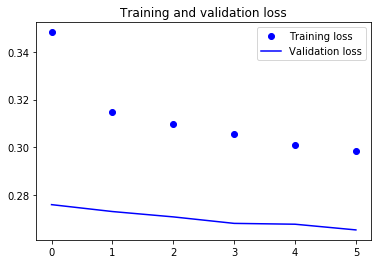

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

## Stacking recurrent layers

In [8]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=3,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/3
500/500 [==============================] - 453s 907ms/step - loss: 0.3331 - val_loss: 0.2762
Epoch 2/3
500/500 [==============================] - 460s 920ms/step - loss: 0.3094 - val_loss: 0.2720
Epoch 3/3
500/500 [==============================] - 468s 937ms/step - loss: 0.3055 - val_loss: 0.2752


## Bidirectional RNNs
使用imdb电影评论数据(温度数据逆序没有效果)

首先尝试**逆序评论**的训练效果,可以发现在该任务中和正序效果基本相同

![bidirectional rnn](https://s3.amazonaws.com/book.keras.io/img/ch6/bidirectional_rnn.png)

In [9]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(path=Path.cwd()/'datasets/imdb.npz', num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=3,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/3
20000/20000 [==============================] - 149s 7ms/step - loss: 0.5192 - acc: 0.7449 - val_loss: 0.4661 - val_acc: 0.8176
Epoch 2/3
20000/20000 [==============================] - 147s 7ms/step - loss: 0.3331 - acc: 0.8704 - val_loss: 0.5138 - val_acc: 0.7716
Epoch 3/3
20000/20000 [==============================] - 139s 7ms/step - loss: 0.2717 - acc: 0.8989 - val_loss: 0.5508 - val_acc: 0.7254


In [17]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 259s 13ms/step - loss: 0.5881 - acc: 0.6938 - val_loss: 0.6167 - val_acc: 0.6536
Epoch 2/5
20000/20000 [==============================] - 255s 13ms/step - loss: 0.3974 - acc: 0.8368 - val_loss: 0.3393 - val_acc: 0.8648
Epoch 3/5
20000/20000 [==============================] - 247s 12ms/step - loss: 0.2991 - acc: 0.8847 - val_loss: 0.5062 - val_acc: 0.8242
Epoch 4/5
20000/20000 [==============================] - 261s 13ms/step - loss: 0.2475 - acc: 0.9076 - val_loss: 0.3722 - val_acc: 0.8800
Epoch 5/5
20000/20000 [==============================] - 254s 13ms/step - loss: 0.2182 - acc: 0.9210 - val_loss: 0.3334 - val_acc: 0.8610


In [13]:
from keras import backend as K
K.clear_session()
# 清理session

## Going even further

* Adjust the number of units in each recurrent layer in the stacked setup. Our current choices are largely arbitrary and thus likely 
suboptimal.
* Adjust the learning rate used by our `RMSprop` optimizer.
* Try using `LSTM` layers instead of `GRU` layers.
* Try using a bigger densely-connected regressor on top of the recurrent layers, i.e. a bigger `Dense` layer or even a stack of `Dense` 
layers.
* Don't forget to eventually run the best performing models (in terms of validation MAE) on the test set! Least you start developing 
architectures that are overfitting to the validation set.   